# Task4 HYPERSPECTRAL CLASSIFICATION——PART2

### 本任务的目的是学习高光谱数据的处理构建语义分割网络实现高光谱分类。

1. 了解遥感数据读写方法
2. 高光谱处理技术
3. 样本增广策略
4. 大区域目标推理策略

In [1]:
from keras import backend as K
#import tensorflow as tf
import os
import numpy as np
import random
from keras.initializers import glorot_uniform
from keras.models import Model,load_model
from keras.layers import Conv2D,Concatenate,Input,Dropout,ZeroPadding2D,\
	AveragePooling2D,BatchNormalization,Activation,Add,UpSampling2D,MaxPooling2D,Reshape,Lambda
from keras.preprocessing.image import img_to_array
from keras.utils.np_utils import to_categorical
from keras.callbacks import  ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from keras.utils import plot_model
# import pydot
from keras.optimizers import Adam,Adamax,Nadam,Adadelta,SGD,RMSprop
from keras.callbacks import CSVLogger,ReduceLROnPlateau
import h5py
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageEnhance, ImageOps, ImageFile
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,TensorBoard
import time
from allmodel import all_model
from utils import *
from historycal import LossHistory
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


# load data

In [2]:
hdf5_path = "Y:\\Deep learning teaching\\task4\\data\\hyper_pca_6b_4c_288.hdf5" 
fd = h5py.File(hdf5_path)
fd.keys()
images,labels=np.asarray(fd['image']),np.asarray(fd['label'])
# images,labels=np.asarray((fd['image'])[:20000]),np.asarray((fd['label'])[:20000])
fd.close()
n_label=5
print(images.shape,labels.shape)
# plot_func(images/2500,np.expand_dims(labels,axis=3))

(288, 256, 256, 6) (288, 256, 256)


C:\yujunchuan\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


In [5]:
img,msk = get_normalized_patches(images,labels,3,10000,32000,n_label=n_label)
threshold=288
xtrain,xtest,ytrain,ytest=train_test_split(img[:threshold],msk[:threshold],test_size=0.3,shuffle=True,random_state=42)
# xval,yval=img[threshold:],msk[threshold:]
print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape)
# del img,msk,images,labels
# plot_func(xtrain*4,ytrain)

(201, 256, 256, 6) (87, 256, 256, 6) (201, 256, 256, 5) (87, 256, 256, 5)


In [7]:
loss='categorical_crossentropy'#'binary_crossentropy'
optimizer=Adam()#Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#Adam()#SGD(),Adamax(),Adadelta()R
loss_weights=''
metrics=['accuracy']
input_height=256
input_width=256
batch_size=20
epoch=50
nclass=n_label
nchannel=xtrain.shape[-1]
num_train=xtrain.shape[0]
num_val=xtest.shape[0]
ATM=all_model(loss,loss_weights,optimizer,metrics,input_height,input_width,nclass,nchannel)
nickname='cbrrnet'

In [9]:
model=ATM.CBRRNET()#FCN8,UNET_VGG,UNET_MINI,SQUEESE_UNET,DEEPLABV3plus,cbrrnet
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 6)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [10]:
begin_time = time.time()          
checkpoint_DIR = "./checkpoint\\"
if not os.path.exists(checkpoint_DIR):
    os.makedirs(checkpoint_DIR) 
model_checkpoint = ModelCheckpoint(filepath=checkpoint_DIR+nickname+"-{epoch:02d}e-val_loss{val_loss:2f}.hdf5",monitor="val_loss",save_best_only=True,mode='auto')
histories=LossHistory()
csvlogger =CSVLogger(filename=checkpoint_DIR+nickname+'-'+str(epoch)+'-log.csv', separator=',', append=False)
# result=model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epoch, verbose=1, shuffle=True,validation_data=(xtest, ytest),callbacks=[model_checkpoint,CSVLogger])
result=model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epoch, verbose=1, shuffle=True,validation_data=(xtest, ytest),callbacks=[model_checkpoint,histories,csvlogger])
end_time = time.time()
print('time lapsing {0} s \n'.format(end_time - begin_time))

Train on 201 samples, validate on 87 samples
Epoch 1/50
201/201 [==============================] - 29s 144ms/step - loss: 0.8171 - acc: 0.7380 - val_loss: 2.7170 - val_acc: 0.7460
Epoch 2/50
201/201 [==============================] - 8s 42ms/step - loss: 0.5291 - acc: 0.8410 - val_loss: 2.4292 - val_acc: 0.7813
Epoch 3/50
201/201 [==============================] - 8s 42ms/step - loss: 0.4484 - acc: 0.8639 - val_loss: 0.6420 - val_acc: 0.8659
Epoch 4/50
201/201 [==============================] - 8s 42ms/step - loss: 0.4245 - acc: 0.8679 - val_loss: 0.3952 - val_acc: 0.8915
Epoch 5/50
201/201 [==============================] - 8s 42ms/step - loss: 0.3188 - acc: 0.9024 - val_loss: 0.3004 - val_acc: 0.9074
Epoch 6/50
201/201 [==============================] - 8s 42ms/step - loss: 0.3417 - acc: 0.8968 - val_loss: 0.3369 - val_acc: 0.8926
Epoch 7/50
201/201 [==============================] - 8s 42ms/step - loss: 0.3187 - acc: 0.9015 - val_loss: 0.2919 - val_acc: 0.9125
Epoch 8/50
201/201 [==

In [ ]:
histories.loss_plot('epoch',nickname)
histories.loss_plot('batch',nickname)
h5_path ="./checkpoint\\"+nickname+"_train_history_"+str(epoch)+".h5"
histories.h5_save(h5_path)
print("history already saved!")

In [12]:
inputdata='Y:\\Deep learning teaching\\task4\\data\\hyper_pca_6b_5c.tif'
img_file, img_bands, img_height, img_width, img_arr, geomatrix, projection = Load_image_by_Gdal(inputdata)
newimg=img_arr.transpose(( 1, 2,0))
newimg=np.expand_dims(newimg,axis=0)
normdata=data_split(newimg[:,:,:,:-1],3,10000,32000)
testlabel=newimg[:,:,:,-1]
PREDICTION_DIR = "./prediction\\"+nickname+'\\'
if not os.path.exists(PREDICTION_DIR):
    os.makedirs(PREDICTION_DIR)

print("[INFO] finish loading!")
begin_time = time.time()   
normdata.reshape((normdata.shape[1:]))
model=load_model('./checkpoint\\cbrrnet-48e-val_loss0.204259.hdf5')
outfile=PREDICTION_DIR+nickname+'_'+str(n_label)+'_pred.tif'
msk_result,mask_arr=predict(model,normdata.reshape(normdata.shape[1:]),PREDICTION_DIR,nickname,0.5,n_label)
resulttif=(mask_arr.transpose(( 2,0,1)))*10000
result=np.asarray(resulttif,dtype='uint16')
Write_Tiff(result, geomatrix, projection,outfile)
argmax_out(result,geomatrix,projection,PREDICTION_DIR+nickname+'_'+str(n_label)+'_class.tif',5000)

loadtime=end_time - begin_time
print('time lapsing {0} s \n'.format(loadtime))


409.0 4700.0
0.0 30124.0
[INFO] finish loading!
all images=1680
processing.....0    of   40
processing.....10    of   40
processing.....20    of   40
processing.....30    of   40
./prediction\cbrrnet\cbrrnet_5_pred.tif 5348 5034 5 2
(5, 5034, 5348) 1
./prediction\cbrrnet\cbrrnet_5_class.tif 5348 5034 1 6
time lapsing -793.5300185680389 s 



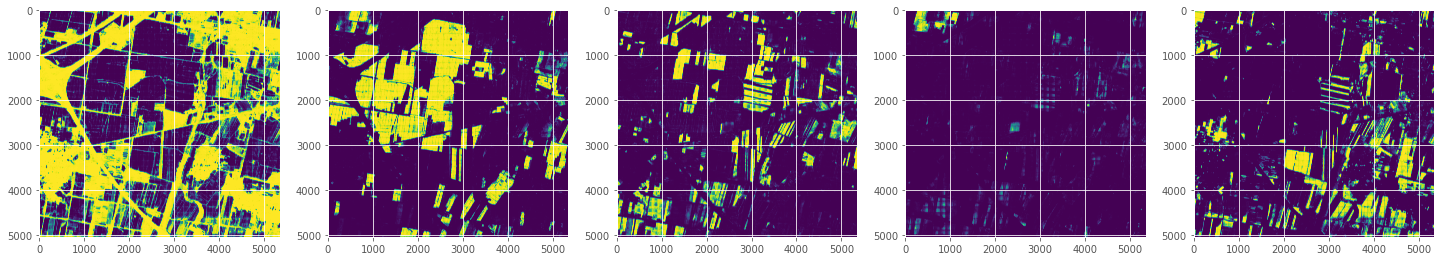

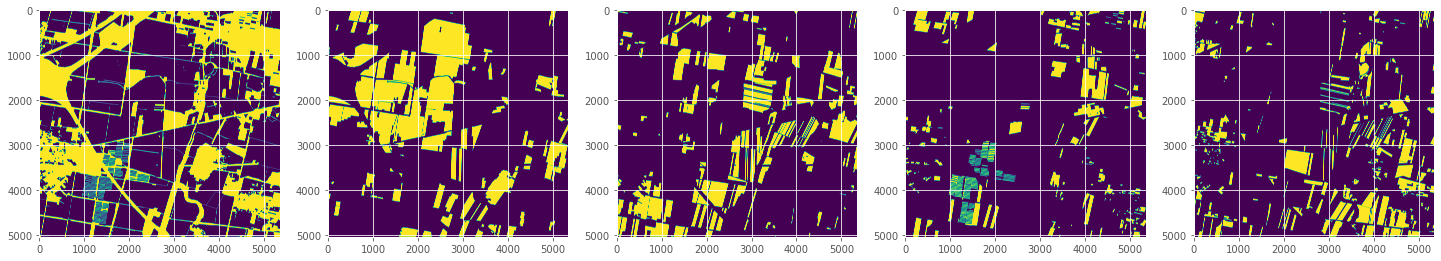

In [13]:
plot_label_func(mask_arr,(label_hot(testlabel,n_label))[0,:,:,:],n_label)